<a href="https://colab.research.google.com/github/chris051091/Tesis_Maestria/blob/main/eventos_nuevos/maps_nuevo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall shapely -y
!pip install shapely --no-binary shapely
# !pip install cartopy
!pip install git+https://github.com/SciTools/cartopy.git --no-binary cartopy
!pip install netCDF4 

Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.5/275.5 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shapely: filename=shapely-2.0.1-cp310-cp310-linux_x86_64.whl size=969595 sha256=a3bd3c06899306bf3fe2a9dd59c76f0998f3357d522c472680d6b4a0d436bd88
  Stored in directory: /root/.cache/pip/wheels/07/bd/06/4e979fa263bca266484ee65f5aab8e6b1c9b20f8caa6f2d7da
Successfully built shapely
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/SciTools/cartopy.git to /tmp/pip-req-build-_3vodpgs
  Running command git clone --filter=blob:none --qu

# **Importar Bibliotecas**

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import io
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import LinearSegmentedColormap
from urllib.request import urlopen, Request
from PIL import Image
from netCDF4 import Dataset
import cartopy.feature as cfeature
from scipy.ndimage.filters import gaussian_filter

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

<ipython-input-2-d76a455277fb>:14: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


Mounted at /content/drive


In [3]:
!mkdir -p drive/MyDrive/Seminario-3-master/figure

In [4]:
#***********************************
# Una escala de colores especial (opcional):
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
   import matplotlib.colors as colors
   new_cmap = colors.LinearSegmentedColormap.from_list(
       'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
       cmap(np.linspace(minval, maxval, n)))
   return new_cmap


def registerColorMap(count, typeCmap = 'gray', nameNewCmap = ''):
    # ncolors = int(count.max())
    ncolors = 85
    color_array = plt.get_cmap(typeCmap)(range(ncolors))
    
    # Cambia transparencia de los colores (alpha) considerando el mayor número de repeticiones
    color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

    # Crea el ColorMap Object
    nameNewCmap = typeCmap + '_' if nameNewCmap == '' else nameNewCmap
    
    return LinearSegmentedColormap.from_list(name=nameNewCmap, colors=color_array), nameNewCmap



# **Configuración de directorios y nombres de los archivos**


In [5]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/dados/'
PATH_FIGURE = '/Figure_nuevo/'
FILE_DATOS_ESTACION = 'events_nuevo_ajustado.csv'
FILE_RELIEVE = 'GMRTv3_8_20210316topo_LR.grd'

In [6]:
df = pd.read_csv(PATH_DRIVE + PATH_DADOS + FILE_DATOS_ESTACION, 
                 sep = ';'
                )

In [7]:
#***********************************
# Estima el histograma 2D de los campos  
count, x_coord, y_coord = np.histogram2d(np.array(df['LON'], dtype=float),
                                          np.array(df['LAT'], dtype=float), bins = [14, 26], range= [[-75.05,-73.05],[4.84,8.56]])

area = 15.93*15.91
count = count/(area*7) #Poner en densidad == eventos/ km cuadrados * años



# **Configuración del mapa**

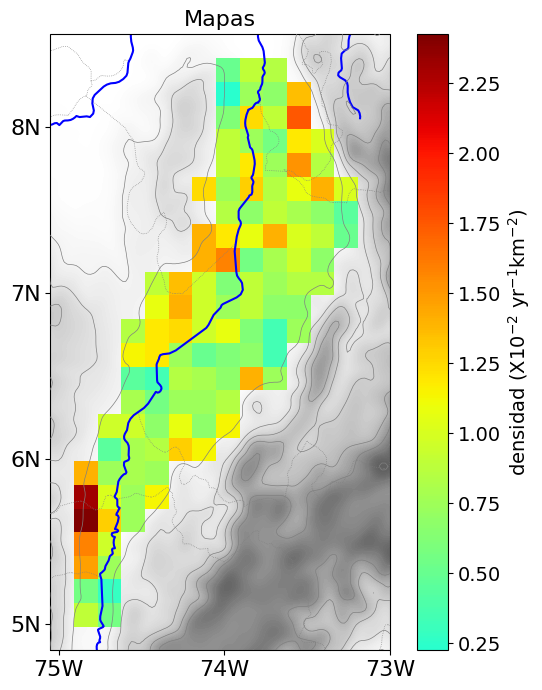

In [9]:
#***********************************
# Configura el mapa
fig = plt.figure(figsize=(7,8))
ax1 = plt.axes(projection=ccrs.Mercator(central_longitude=-75))
ax1.set_title('Mapas',fontsize=16)
extent = [-75.05, -73.05, 4.84, 8.56]
ax1.set_extent(extent)
ax1.set_xticks(np.arange(-75,-72),crs=ccrs.PlateCarree()) # Configura los indicadores de longitud
ax1.set_yticks(np.arange(5,9),crs=ccrs.PlateCarree()) # Configura los indicadores de latitud
lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='',dateline_direction_label=True) # Formata longitud
lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='') # Formata Latitud  
ax1.xaxis.set_major_formatter(lon_formatter) # Configura Longitud
ax1.yaxis.set_major_formatter(lat_formatter) # Configura Latitud
ax1.tick_params(labelsize=16)

#***********************************
# Ríos, fronteras, etc:

rios = cfeature.NaturalEarthFeature(
       category='physical',
       name='rivers_lake_centerlines',
       scale='10m',
       facecolor='none' )
limites_dep = cfeature.NaturalEarthFeature(
   category='cultural',
   name='admin_1_states_provinces_lines',
   scale='10m',
   facecolor='none')
limites_int = cfeature.NaturalEarthFeature(
   category='cultural',
   name='admin_0_countries',
   scale='10m',
   facecolor='none')
ax1.add_feature(limites_int, edgecolor='0.5',linewidth=0.5, linestyle=':') #estos dos son opcionales
ax1.add_feature(limites_dep, edgecolor='0.5',linewidth=0.5, linestyle=':')
ax1.add_feature(rios, edgecolor='blue', linewidth=1.5 ) # los ríos son importantes

#***********************************
#datos de altura:

var2 = Dataset(PATH_DRIVE + PATH_DADOS + FILE_RELIEVE, mode='r')
xtopo=np.arange(var2.variables['x_range'][0],var2.variables['x_range'][1]+0.5*var2.variables['spacing'][0],var2.variables['spacing'][0])
ytopo=np.arange(var2.variables['y_range'][0],var2.variables['y_range'][1]+0.5*var2.variables['spacing'][1],var2.variables['spacing'][1])
z=var2.variables['z'][:]
var2.close()
xt0,yt0=np.meshgrid(xtopo,ytopo)
z=np.reshape(z,xt0.shape)[::-1,:]
# suavizar los datos de altura:
z=gaussian_filter(z,2)
# niveles de elevación en escala de grises
plt.contourf(xt0,yt0,z, cmap='Greys', levels=np.arange(0,5100,50), zorder=0, transform=ccrs.PlateCarree(),alpha=1)
# líneas de contorno de elevación
plt.contour(xt0,yt0,z,levels=np.arange(0,5100,500),colors='gray',linewidths=[0.5],zorder=10,transform=ccrs.PlateCarree())

#***********************************
# Una escala de colores especial (opcional):
cmap = plt.get_cmap('jet')
jet2 = truncate_colormap(cmap, 0.4, 1)

#***********************************
# Inserta el histograma en el Mapa
count.T[np.where(count.T==0)]=np.nan # para que no grafique los ceros
im = ax1.pcolormesh( x_coord, y_coord, count.T*100, cmap = jet2, transform=ccrs.PlateCarree() )
cb=plt.colorbar(im, ax = ax1)
cb.ax.tick_params(labelsize=14)
cb.set_label('densidad (X10$^{-2}$ yr$^{-1}$km$^{-2}$)', size=14)

# plt.show()
plt.savefig(PATH_DRIVE + PATH_FIGURE + 'Mapa_eventos_Temp.png', format='png', bbox_inches = 'tight' )

In [ ]:
# ===============================================================================================

In [10]:
dfTemp = df[['DATE_MIN_T', 'LON', 'LAT', 'MIN_T']].copy()
dfTemp['hora'] = dfTemp['DATE_MIN_T'].apply(lambda x: x[11:13])


In [ ]:
# ===============================================================================================

# **Mapas Horarios**

Procesando hora 00
Procesando hora 01
Procesando hora 02
Procesando hora 03
Procesando hora 04
Procesando hora 05
Procesando hora 06
Procesando hora 07
Procesando hora 08
Procesando hora 09
Procesando hora 10
Procesando hora 11
Procesando hora 12
Procesando hora 13
Procesando hora 14
Procesando hora 15
Procesando hora 16
Procesando hora 17
Procesando hora 18
Procesando hora 19
Procesando hora 20


<ipython-input-12-a63c94abd361>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(7,8))


Procesando hora 21
Procesando hora 22
Procesando hora 23


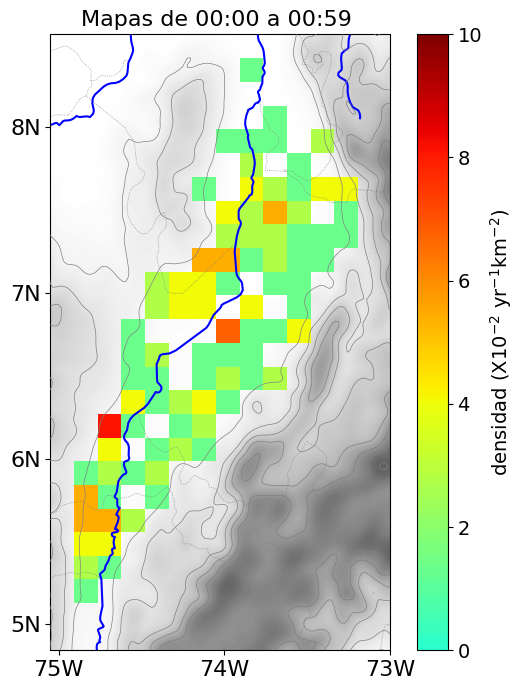

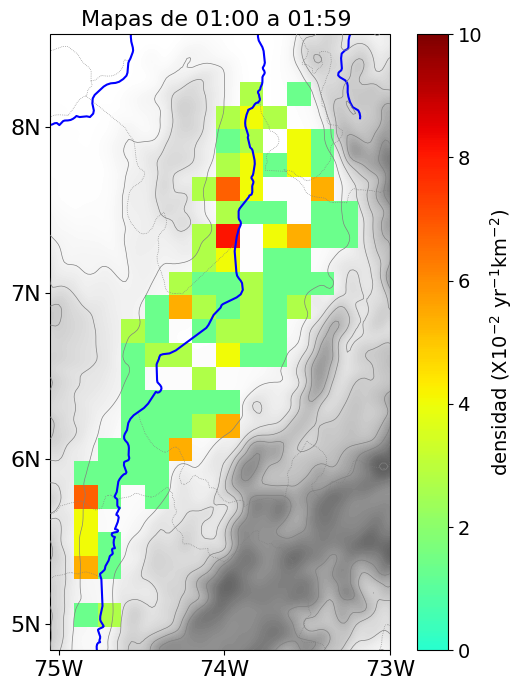

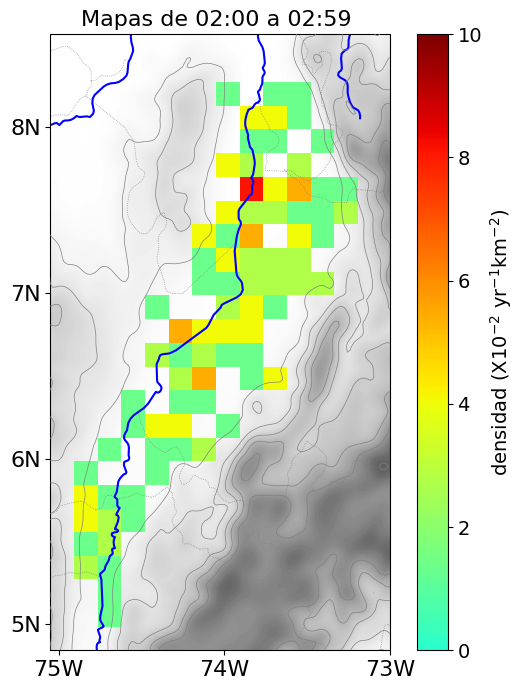

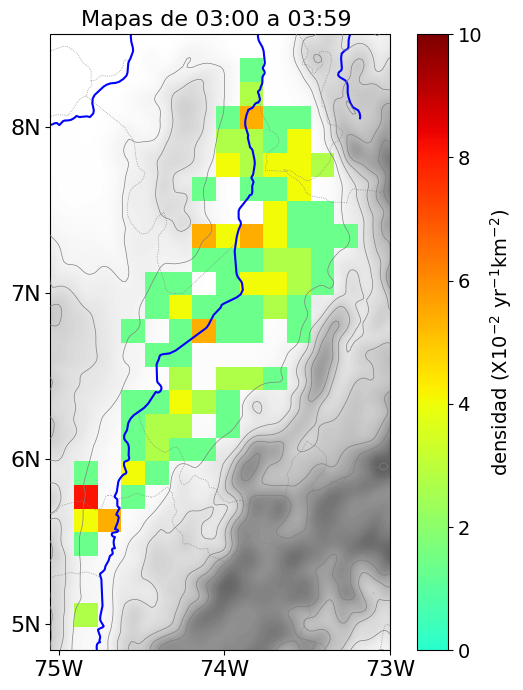

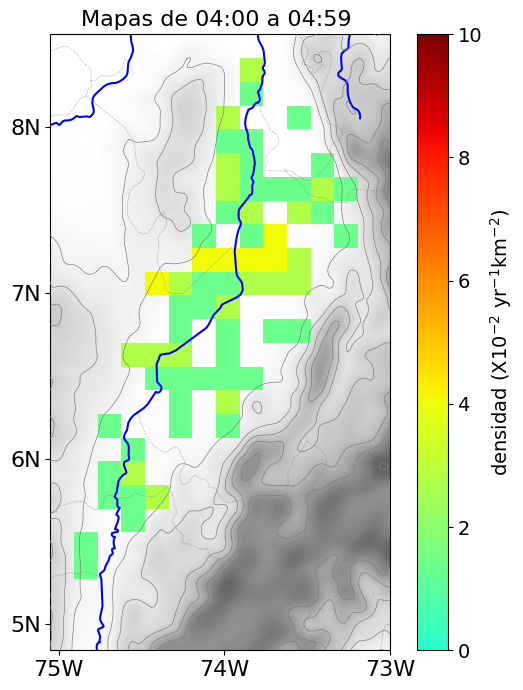

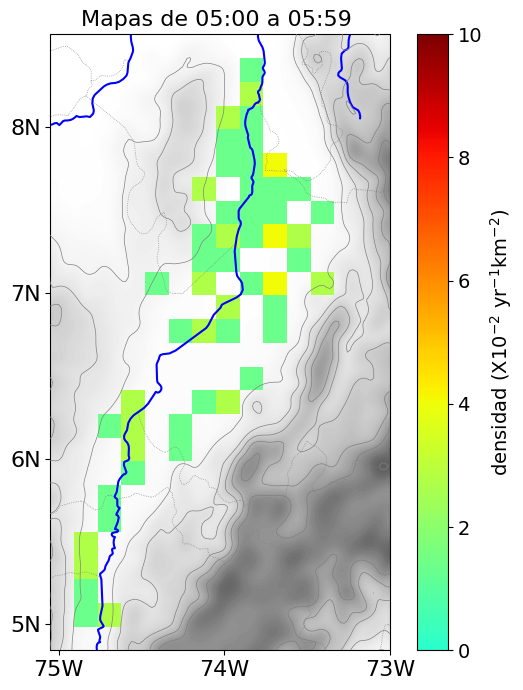

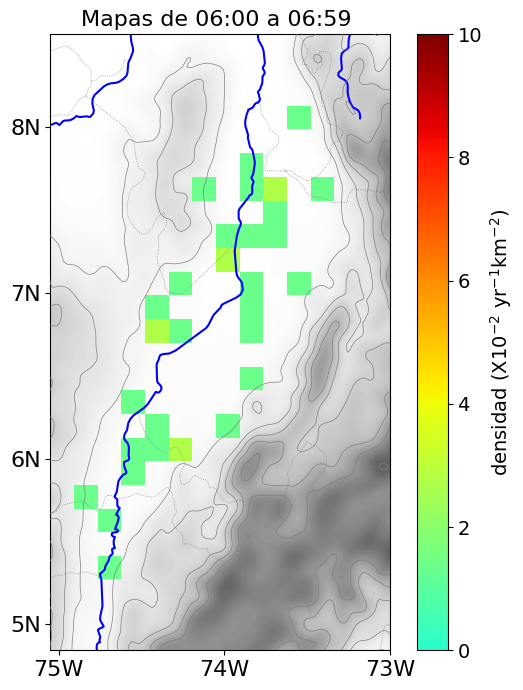

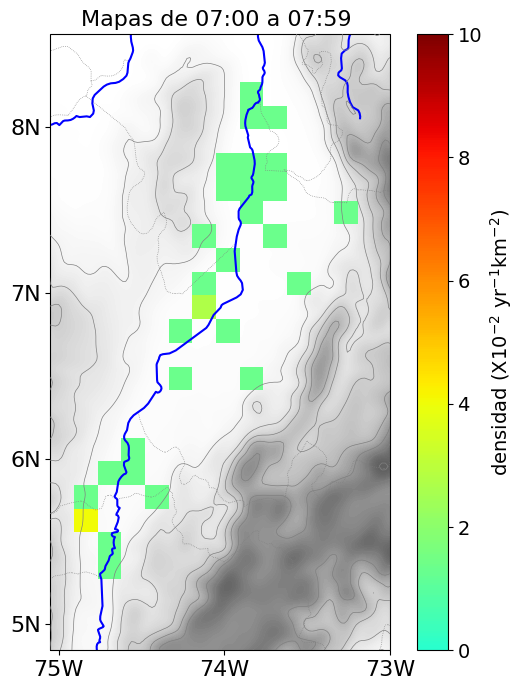

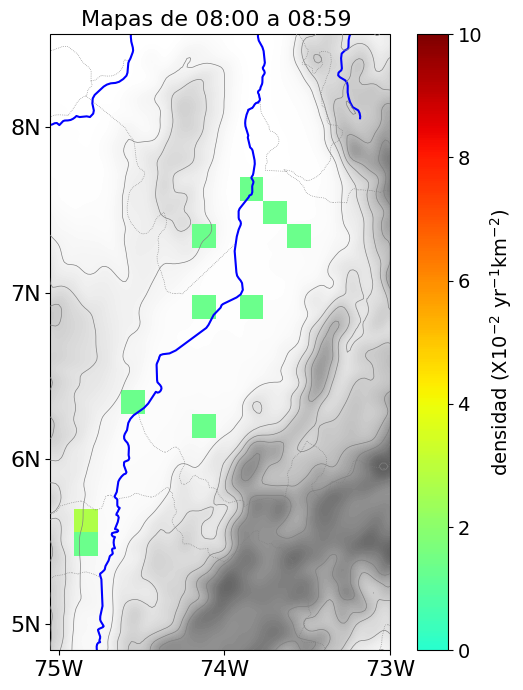

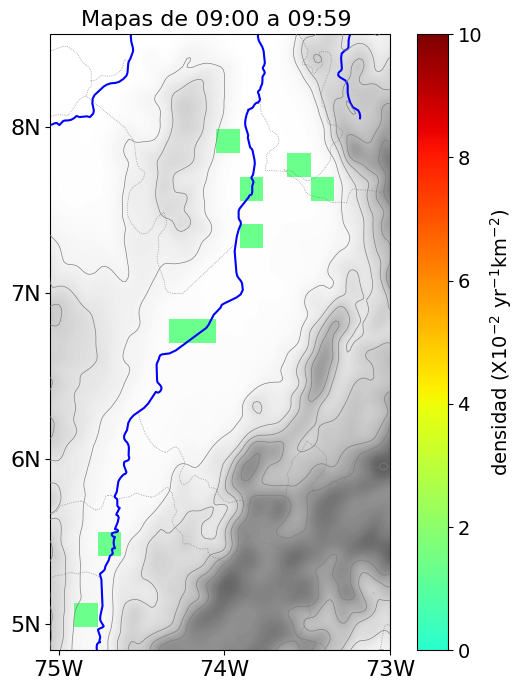

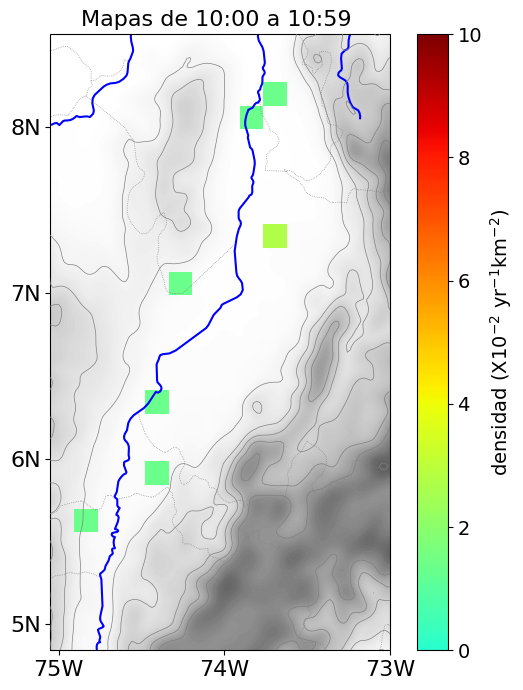

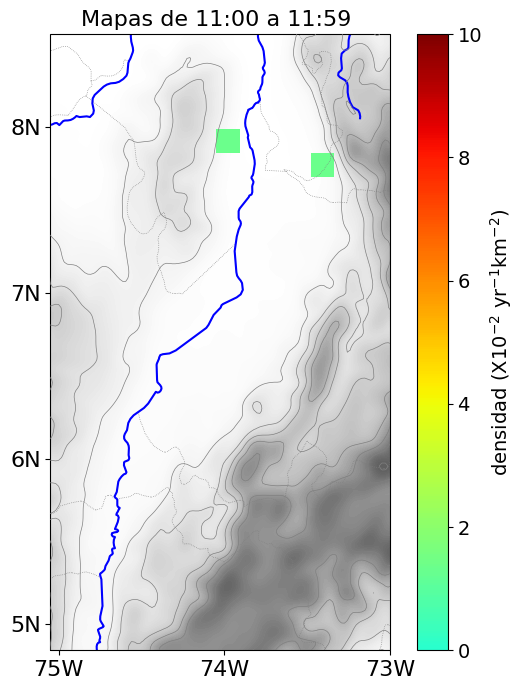

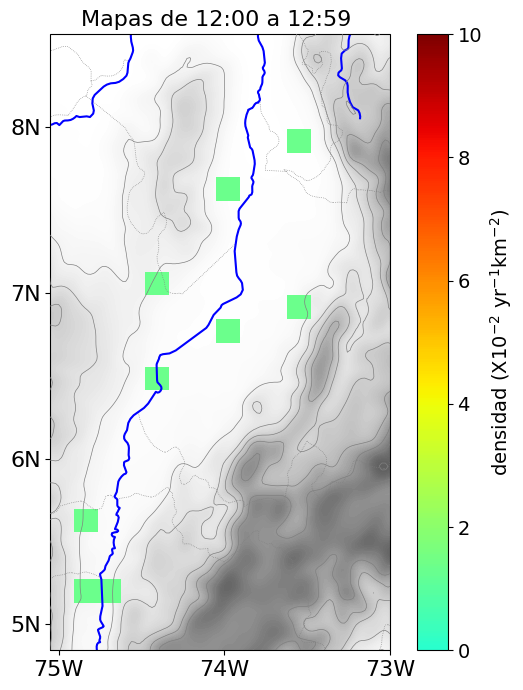

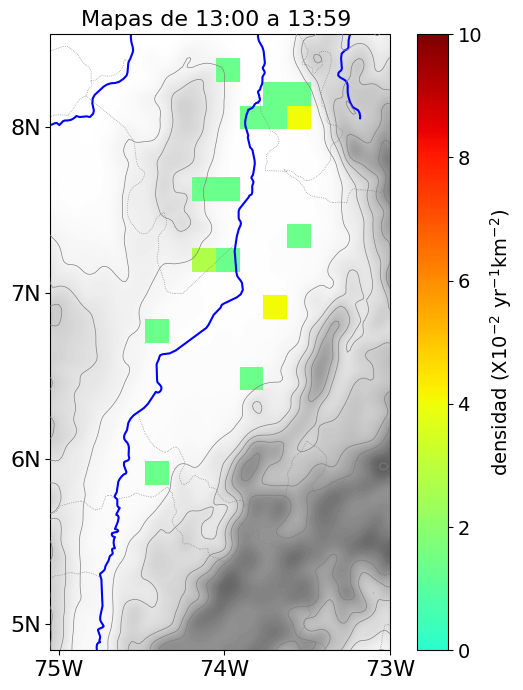

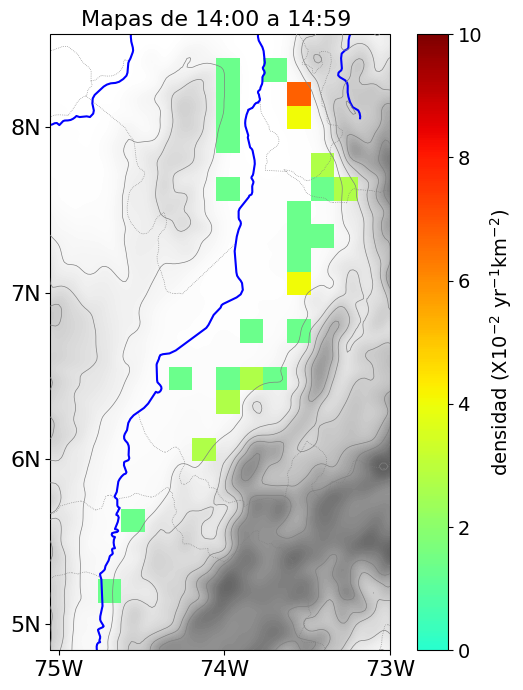

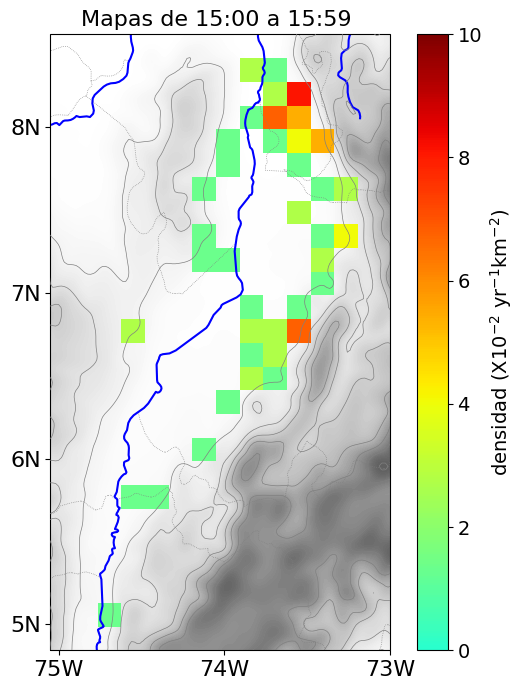

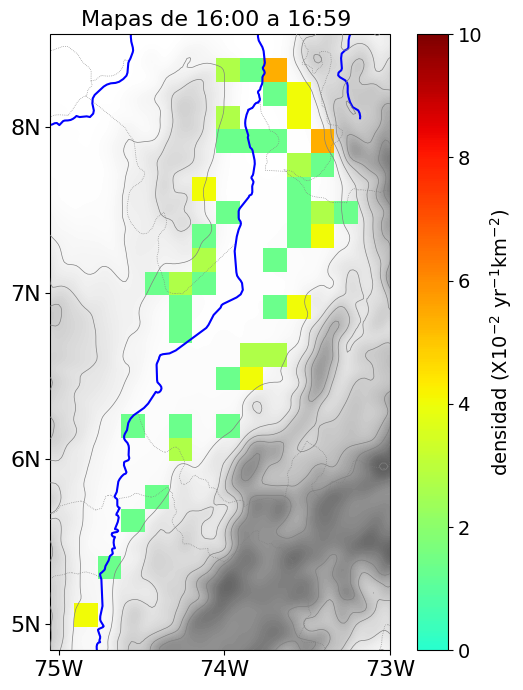

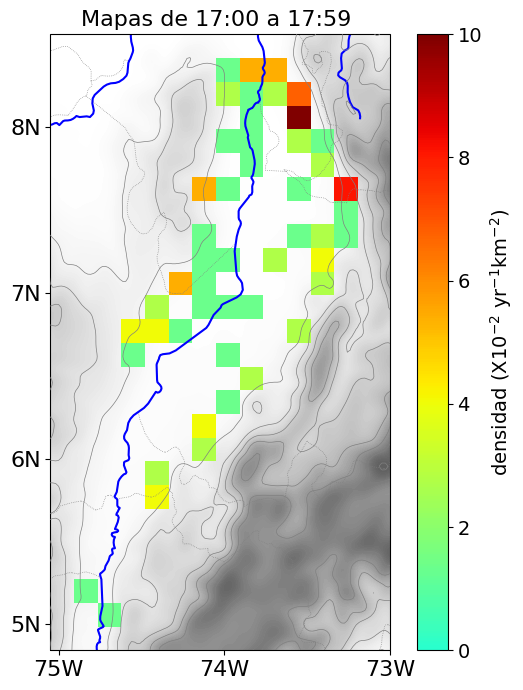

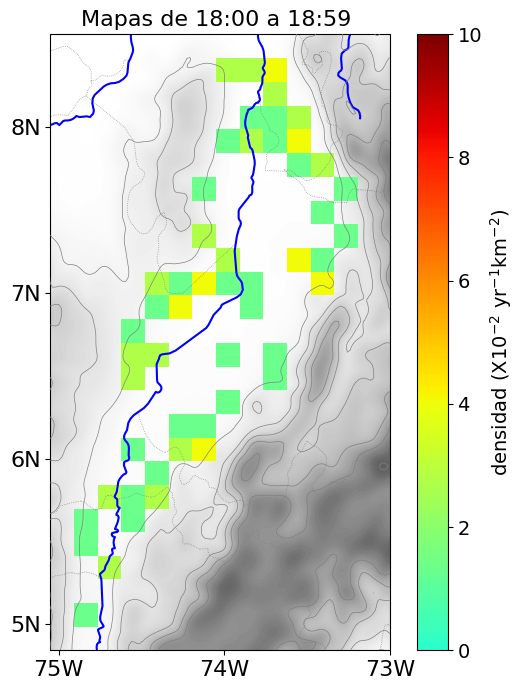

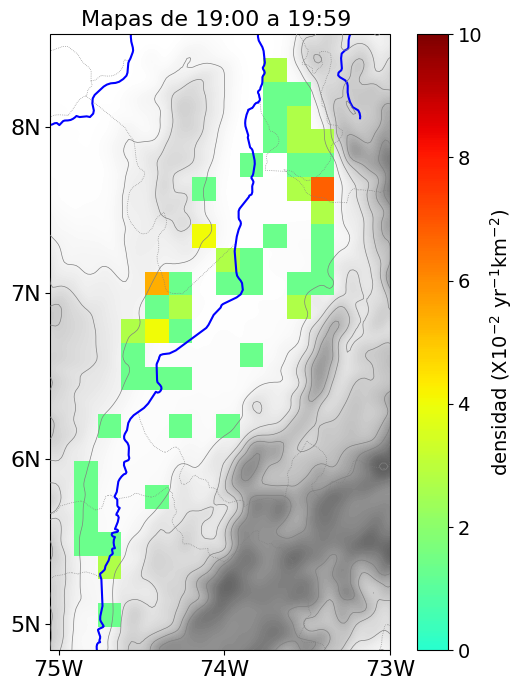

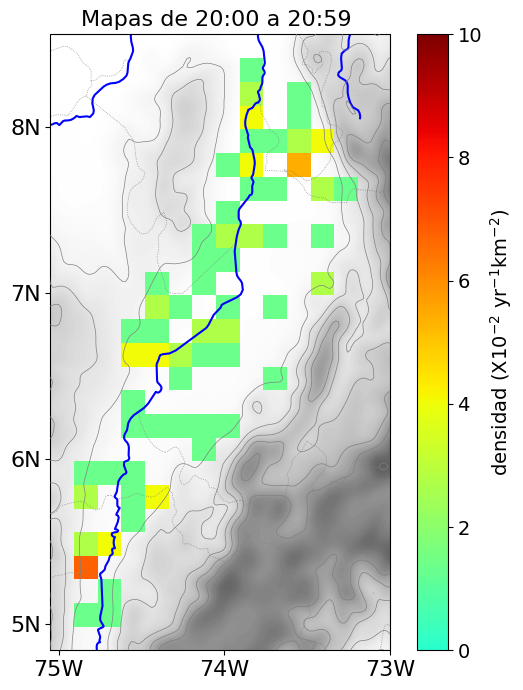

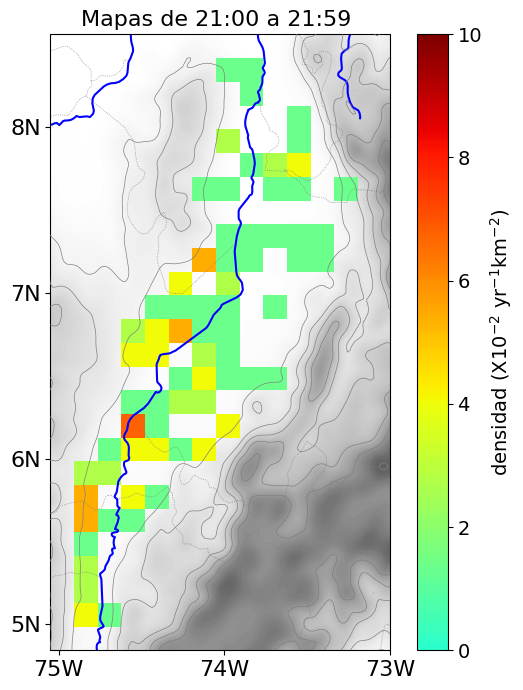

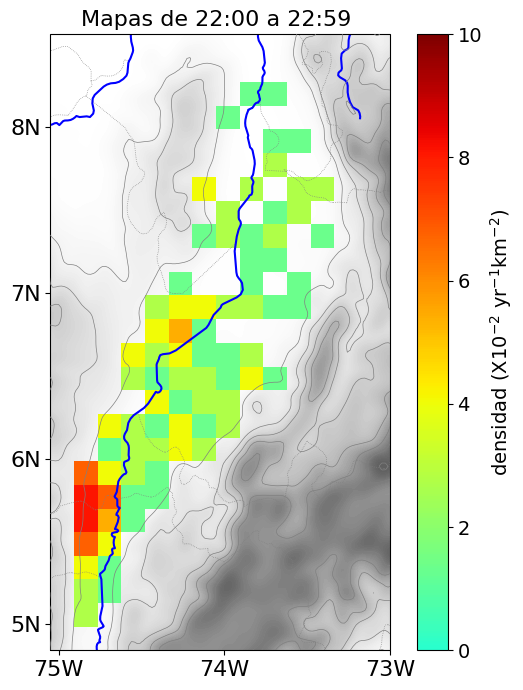

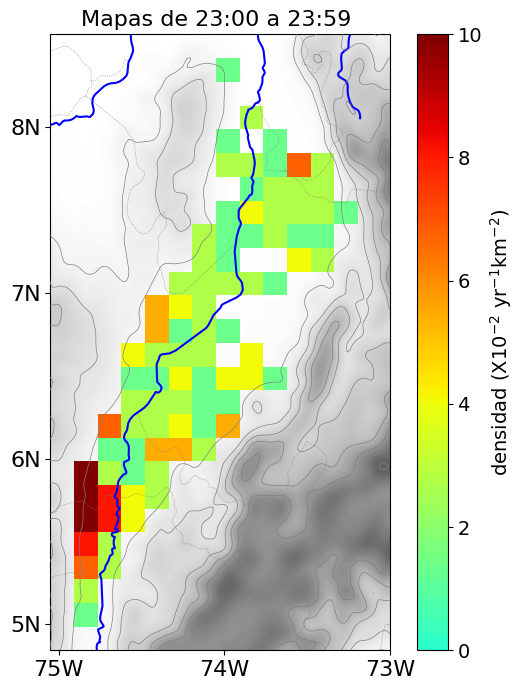

In [12]:
for x in range(0, 24):
  print(f'Procesando hora {str(x).zfill(2)}')
  hora = str(x).zfill(2)
  dfTempSegmentado = dfTemp.loc[dfTemp['hora'] == hora].reset_index(drop=True)

 #***********************************
  # Configura el mapa
  fig = plt.figure(figsize=(7,8))
  ax1 = plt.axes(projection=ccrs.Mercator(central_longitude=-75))
  ax1.set_title(f'Mapas de {hora}:00 a {hora}:59 ',fontsize=16)
  extent = [-75.05, -73.05, 4.84, 8.56]
  ax1.set_extent(extent)
  ax1.set_xticks(np.arange(-75,-72),crs=ccrs.PlateCarree()) # Configura los indicadores de longitud
  ax1.set_yticks(np.arange(5,9),crs=ccrs.PlateCarree()) # Configura los indicadores de latitud
  lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='',dateline_direction_label=True) # Formata longitud
  lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='') # Formata Latitud  
  ax1.xaxis.set_major_formatter(lon_formatter) # Configura Longitud
  ax1.yaxis.set_major_formatter(lat_formatter) # Configura Latitud
  ax1.tick_params(labelsize=16)

  #***********************************
  # Ríos, fronteras, etc:

  rios = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale='10m',
        facecolor='none' )
  limites_dep = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
  limites_int = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='10m',
    facecolor='none')
  ax1.add_feature(limites_int, edgecolor='0.5',linewidth=0.5, linestyle=':') #estos dos son opcionales
  ax1.add_feature(limites_dep, edgecolor='0.5',linewidth=0.5, linestyle=':')
  ax1.add_feature(rios, edgecolor='blue', linewidth=1.5 ) # los ríos son importantes

  #***********************************
  #datos de altura:

  var2 = Dataset(PATH_DRIVE + PATH_DADOS + FILE_RELIEVE, mode='r')
  xtopo=np.arange(var2.variables['x_range'][0],var2.variables['x_range'][1]+0.5*var2.variables['spacing'][0],var2.variables['spacing'][0])
  ytopo=np.arange(var2.variables['y_range'][0],var2.variables['y_range'][1]+0.5*var2.variables['spacing'][1],var2.variables['spacing'][1])
  z=var2.variables['z'][:]
  var2.close()
  xt0,yt0=np.meshgrid(xtopo,ytopo)
  z=np.reshape(z,xt0.shape)[::-1,:]
  # suavizar los datos de altura:
  z=gaussian_filter(z,2)
  # niveles de elevación en escala de grises
  plt.contourf(xt0,yt0,z, cmap='Greys', levels=np.arange(0,5100,50), zorder=0, transform=ccrs.PlateCarree(),alpha=1)
  # líneas de contorno de elevación
  plt.contour(xt0,yt0,z,levels=np.arange(0,5100,500),colors='gray',linewidths=[0.5],zorder=10,transform=ccrs.PlateCarree())

  #***********************************
  # Estima o histograma 2D de los campos
  count, x_coord, y_coord = np.histogram2d(np.array(dfTempSegmentado['LON'], dtype=float), 
                                    np.array(dfTempSegmentado['LAT'], dtype=float), bins = [14, 26], range= [[-75.05,-73.05],[4.84,8.56]])
  
  area = 15.93*15.91
  count = count/(area*(7/24)) #Poner en densidad == eventos/ km cuadrados * años
  
  #***********************************
  # Una escala de colores especial (opcional):
  cmap = plt.get_cmap('jet')
  jet2 = truncate_colormap(cmap, 0.4, 1)

  #***********************************
  # Inserta el histograma en el Mapa
  count.T[np.where(count.T==0)]=np.nan # para que no grafique los ceros
  im = ax1.pcolormesh( x_coord, y_coord, count.T*100, vmin = 0, vmax = 10, cmap = jet2, transform=ccrs.PlateCarree() )
  cb=plt.colorbar(im, ax = ax1)
  cb.ax.tick_params(labelsize=14)
  cb.set_label('densidad (X10$^{-2}$ yr$^{-1}$km$^{-2}$)', size=14)

  # plt.show()

  plt.savefig(PATH_DRIVE + PATH_FIGURE + f'Mapa_eventos_Temp_{hora}.png', format='png', bbox_inches = 'tight' )


# **Mapas cada 3 horas**

Procesando hora 00:00 a 02:59
Tamaño : 478
Procesando hora 03:00 a 05:59
Tamaño : 319
Procesando hora 06:00 a 08:59
Tamaño : 77
Procesando hora 09:00 a 11:59
Tamaño : 19
Procesando hora 12:00 a 14:59
Tamaño : 68
Procesando hora 15:00 a 17:59
Tamaño : 243
Procesando hora 18:00 a 20:59
Tamaño : 248
Procesando hora 21:00 a 23:59
Tamaño : 495


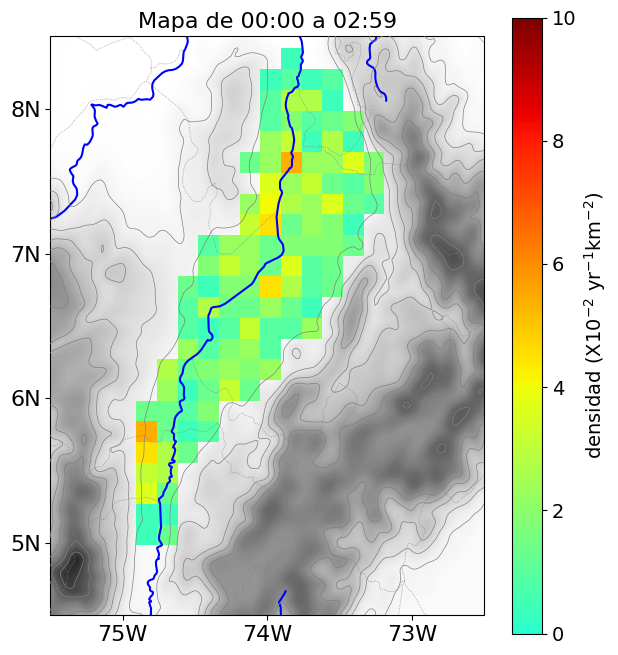

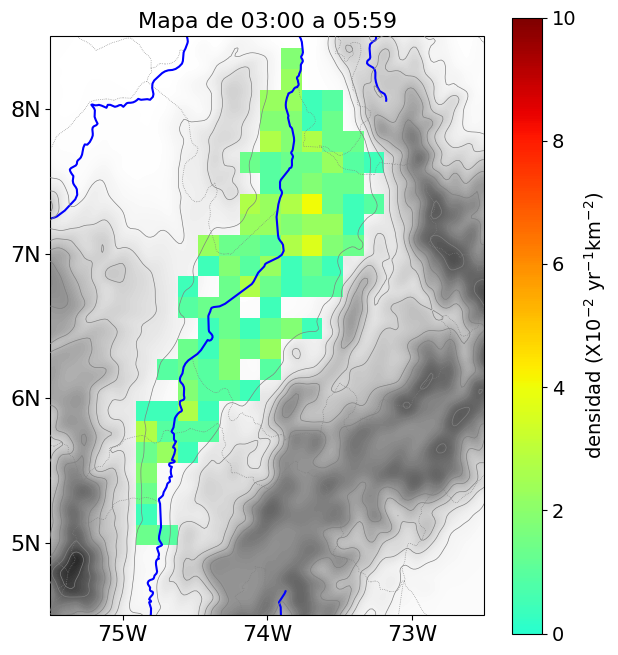

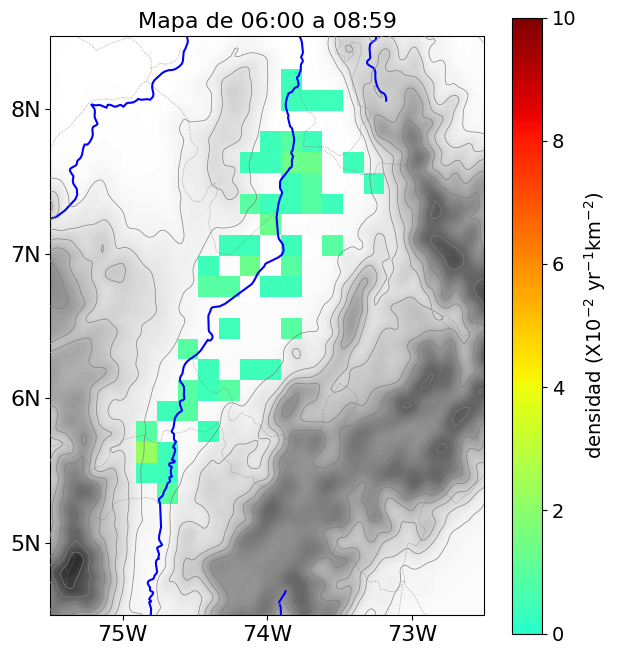

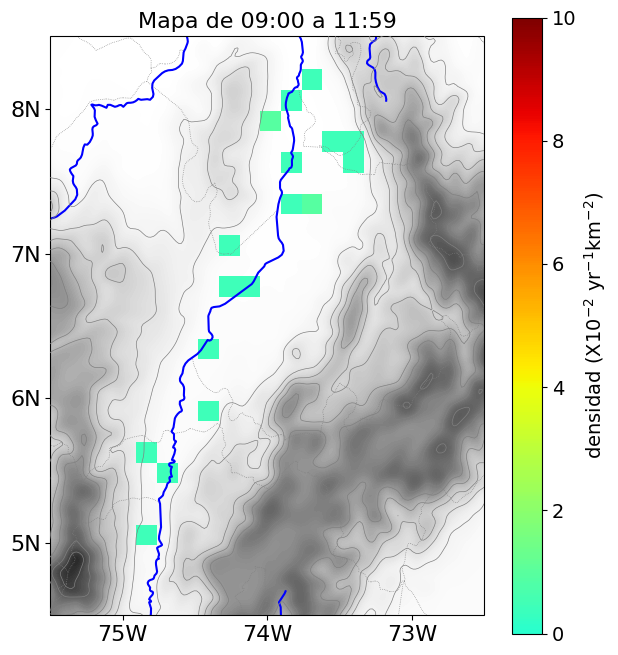

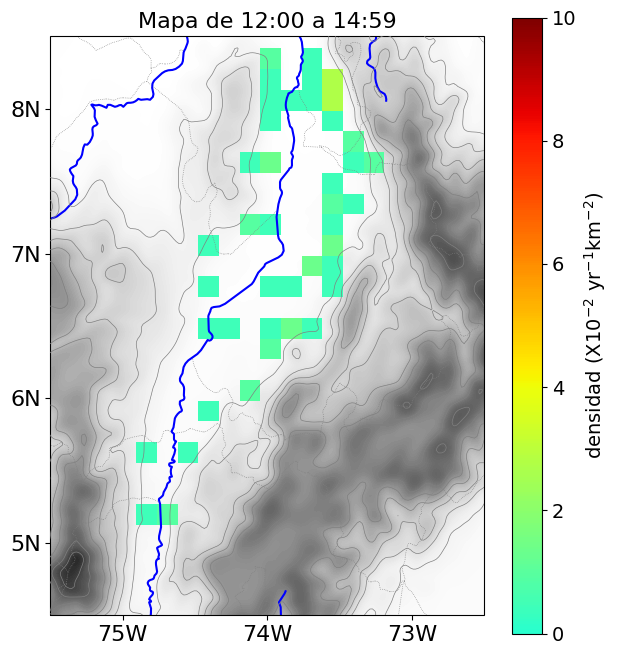

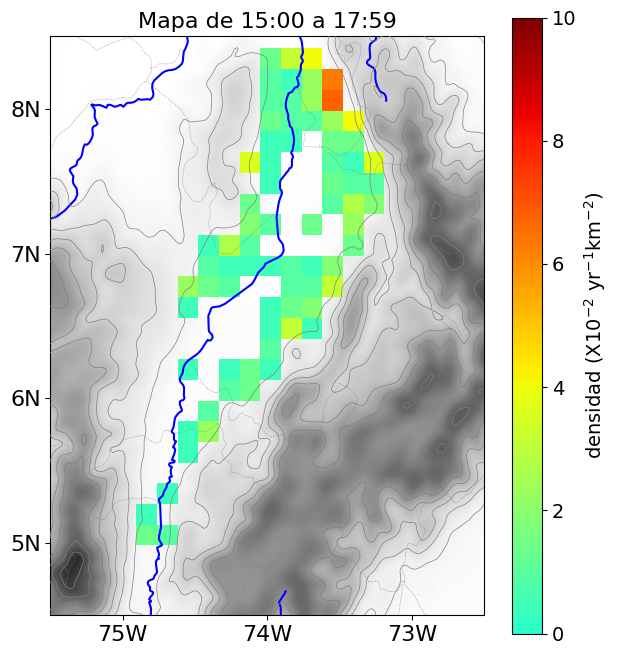

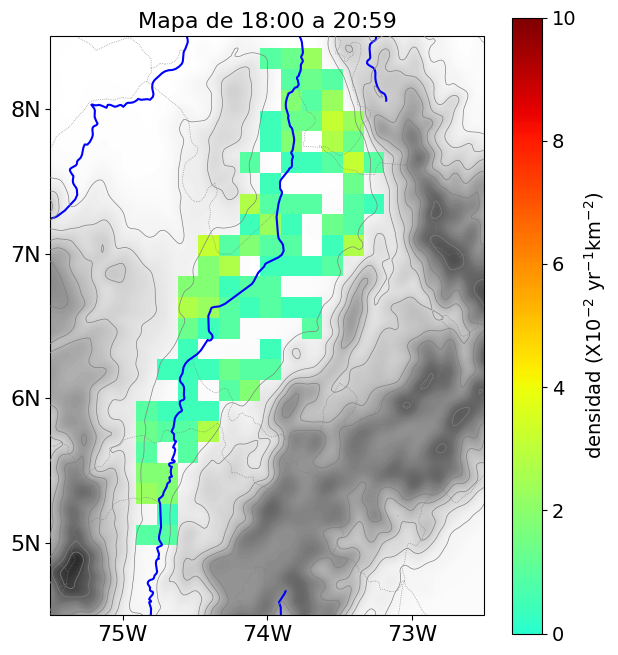

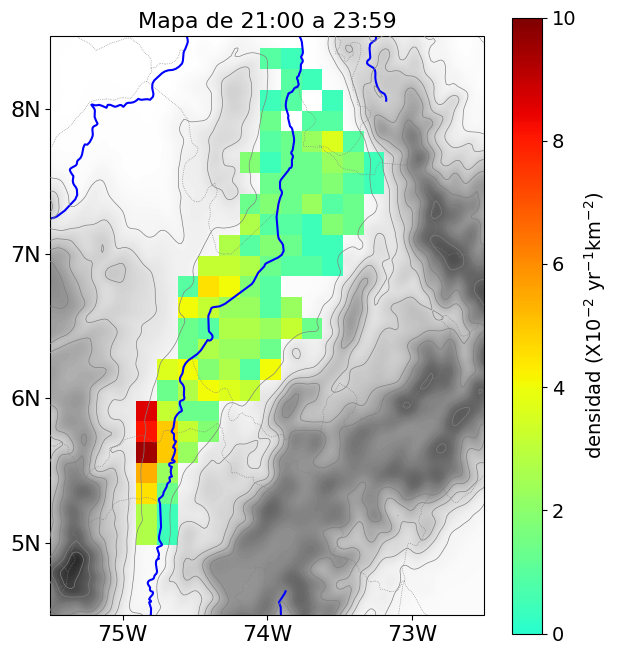

In [13]:
tamano_int_horas = 3
for x in range(0, 24, tamano_int_horas):
  a = list(range(x, x + tamano_int_horas))
  a = [str(r).zfill(2) for r in a]
  print(f'Procesando hora {str(a[0])}:00 a {str(a[-1])}:59')
  dfTempSegmentado = dfTemp.loc[dfTemp['hora'].isin(a)].reset_index(drop=True)
  print(f'Tamaño : {len(dfTempSegmentado)}')

 #***********************************
  # Configura el mapa
  fig = plt.figure(figsize=(7,8))
  ax1 = plt.axes(projection=ccrs.Mercator(central_longitude=-75))
  ax1.set_title(f'Mapa de {str(a[0])}:00 a {str(a[-1])}:59',fontsize=16)
  extent = [-75.5, -72.5, 4.5, 8.5]
  ax1.set_extent(extent)
  ax1.set_xticks(np.arange(-75,-72),crs=ccrs.PlateCarree()) # Configura los indicadores de longitud
  ax1.set_yticks(np.arange(5,9),crs=ccrs.PlateCarree()) # Configura los indicadores de latitud
  lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='',dateline_direction_label=True) # Formata longitud
  lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='') # Formata Latitud  
  ax1.xaxis.set_major_formatter(lon_formatter) # Configura Longitud
  ax1.yaxis.set_major_formatter(lat_formatter) # Configura Latitud
  ax1.tick_params(labelsize=16)

  #***********************************
  # Ríos, fronteras, etc:

  rios = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale='10m',
        facecolor='none' )
  limites_dep = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
  limites_int = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='10m',
    facecolor='none')
  ax1.add_feature(limites_int, edgecolor='0.5',linewidth=0.5, linestyle=':') #estos dos son opcionales
  ax1.add_feature(limites_dep, edgecolor='0.5',linewidth=0.5, linestyle=':')
  ax1.add_feature(rios, edgecolor='blue', linewidth=1.5 ) # los ríos son importantes

  #***********************************
  #datos de altura:

  var2 = Dataset(PATH_DRIVE + PATH_DADOS + FILE_RELIEVE, mode='r')
  xtopo=np.arange(var2.variables['x_range'][0],var2.variables['x_range'][1]+0.5*var2.variables['spacing'][0],var2.variables['spacing'][0])
  ytopo=np.arange(var2.variables['y_range'][0],var2.variables['y_range'][1]+0.5*var2.variables['spacing'][1],var2.variables['spacing'][1])
  z=var2.variables['z'][:]
  var2.close()
  xt0,yt0=np.meshgrid(xtopo,ytopo)
  z=np.reshape(z,xt0.shape)[::-1,:]
  # suavizar los datos de altura:
  z=gaussian_filter(z,2)
  # niveles de elevación en escala de grises
  plt.contourf(xt0,yt0,z, cmap='Greys', levels=np.arange(0,5100,50), zorder=0, transform=ccrs.PlateCarree(),alpha=1)
  # líneas de contorno de elevación
  plt.contour(xt0,yt0,z,levels=np.arange(0,5100,500),colors='gray',linewidths=[0.5],zorder=10,transform=ccrs.PlateCarree())

  #***********************************
  # Estima o histograma 2D de los campos
  count, x_coord, y_coord = np.histogram2d(np.array(dfTempSegmentado['LON'], dtype=float), 
                                    np.array(dfTempSegmentado['LAT'], dtype=float), bins = [14, 26], range= [[-75.05,-73.05],[4.84,8.56]])
  
  area = 15.93*15.91
  count = count/((area*7*tamano_int_horas)/24) #Poner en densidad == eventos/ km cuadrados * años)
  
  
  #***********************************
  # Una escala de colores especial (opcional):
  cmap = plt.get_cmap('jet')
  jet2 = truncate_colormap(cmap, 0.4, 1)

  #***********************************
  # Inserta el histograma en el Mapa
  count.T[np.where(count.T==0)]=np.nan # para que no grafique los ceros
  im = ax1.pcolormesh( x_coord, y_coord, count.T*100, vmin = 0, vmax = 10, cmap = jet2, transform=ccrs.PlateCarree() )
  cb=plt.colorbar(im, ax = ax1)
  cb.ax.tick_params(labelsize=14)
  cb.set_label('densidad (X10$^{-2}$ yr$^{-1}$km$^{-2}$)', size=14)

  # plt.show()

  plt.savefig(PATH_DRIVE + PATH_FIGURE + f'Mapa_eventos_Temp_cada 3 horas_de_{str(a[0])}:00_a_{str(a[-1])}:59.png', format='png', bbox_inches = 'tight' )

#**Mapa cada 6 horas**

Procesando hora 00:00 a 05:59
Tamaño : 797
Procesando hora 06:00 a 11:59
Tamaño : 96
Procesando hora 12:00 a 17:59
Tamaño : 311
Procesando hora 18:00 a 23:59
Tamaño : 743


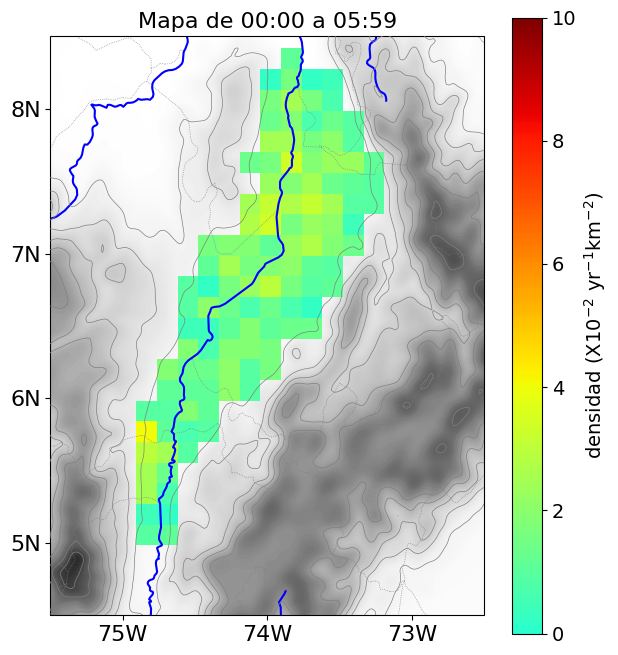

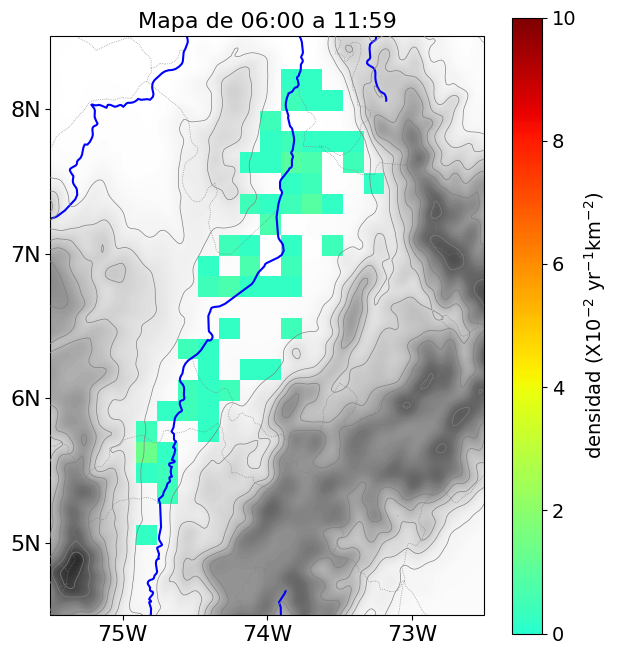

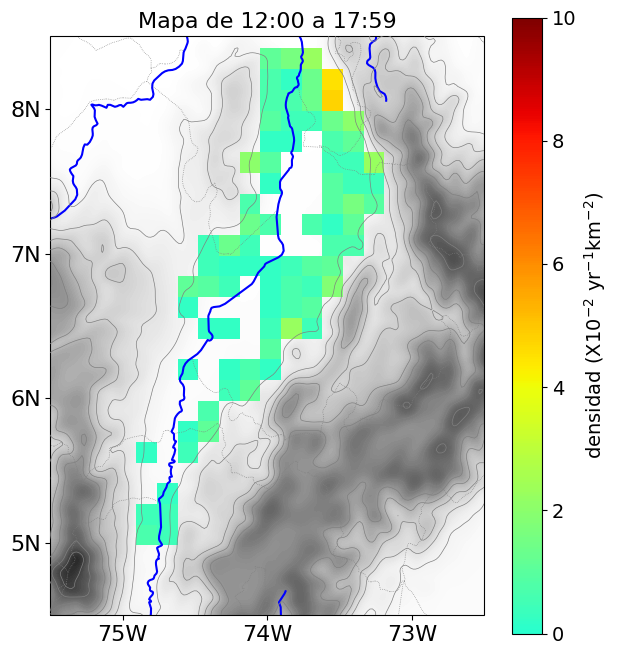

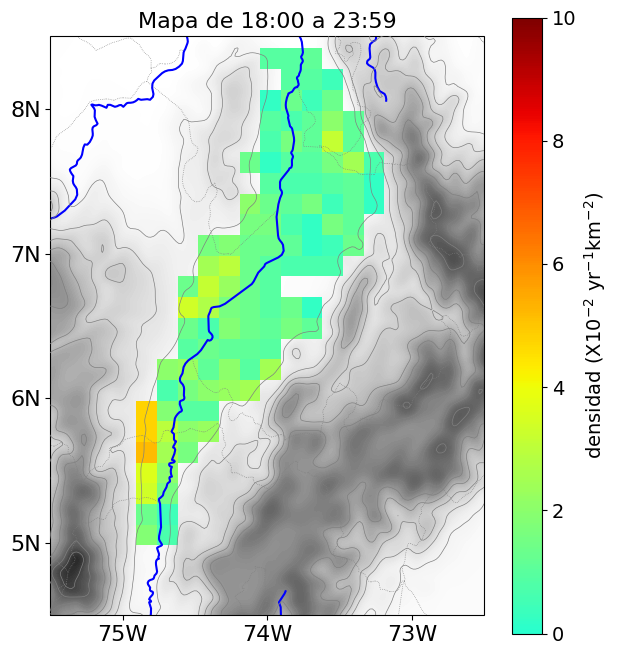

In [14]:
tamano_int_horas = 6
for x in range(0, 24, tamano_int_horas):
  a = list(range(x, x + tamano_int_horas))
  a = [str(r).zfill(2) for r in a]
  print(f'Procesando hora {str(a[0])}:00 a {str(a[-1])}:59')
  dfTempSegmentado = dfTemp.loc[dfTemp['hora'].isin(a)].reset_index(drop=True)
  print(f'Tamaño : {len(dfTempSegmentado)}')

 #***********************************
  # Configura el mapa
  fig = plt.figure(figsize=(7,8))
  ax1 = plt.axes(projection=ccrs.Mercator(central_longitude=-75))
  ax1.set_title(f'Mapa de {str(a[0])}:00 a {str(a[-1])}:59',fontsize=16)
  extent = [-75.5, -72.5, 4.5, 8.5]
  ax1.set_extent(extent)
  ax1.set_xticks(np.arange(-75,-72),crs=ccrs.PlateCarree()) # Configura los indicadores de longitud
  ax1.set_yticks(np.arange(5,9),crs=ccrs.PlateCarree()) # Configura los indicadores de latitud
  lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='',dateline_direction_label=True) # Formata longitud
  lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='') # Formata Latitud  
  ax1.xaxis.set_major_formatter(lon_formatter) # Configura Longitud
  ax1.yaxis.set_major_formatter(lat_formatter) # Configura Latitud
  ax1.tick_params(labelsize=16)

  #***********************************
  # Ríos, fronteras, etc:

  rios = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale='10m',
        facecolor='none' )
  limites_dep = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
  limites_int = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='10m',
    facecolor='none')
  ax1.add_feature(limites_int, edgecolor='0.5',linewidth=0.5, linestyle=':') #estos dos son opcionales
  ax1.add_feature(limites_dep, edgecolor='0.5',linewidth=0.5, linestyle=':')
  ax1.add_feature(rios, edgecolor='blue', linewidth=1.5 ) # los ríos son importantes

  #***********************************
  #datos de altura:

  var2 = Dataset(PATH_DRIVE + PATH_DADOS + FILE_RELIEVE, mode='r')
  xtopo=np.arange(var2.variables['x_range'][0],var2.variables['x_range'][1]+0.5*var2.variables['spacing'][0],var2.variables['spacing'][0])
  ytopo=np.arange(var2.variables['y_range'][0],var2.variables['y_range'][1]+0.5*var2.variables['spacing'][1],var2.variables['spacing'][1])
  z=var2.variables['z'][:]
  var2.close()
  xt0,yt0=np.meshgrid(xtopo,ytopo)
  z=np.reshape(z,xt0.shape)[::-1,:]
  # suavizar los datos de altura:
  z=gaussian_filter(z,2)
  # niveles de elevación en escala de grises
  plt.contourf(xt0,yt0,z, cmap='Greys', levels=np.arange(0,5100,50), zorder=0, transform=ccrs.PlateCarree(),alpha=1)
  # líneas de contorno de elevación
  plt.contour(xt0,yt0,z,levels=np.arange(0,5100,500),colors='gray',linewidths=[0.5],zorder=10,transform=ccrs.PlateCarree())

  #***********************************
  # Estima o histograma 2D de los campos
  count, x_coord, y_coord = np.histogram2d(np.array(dfTempSegmentado['LON'], dtype=float), 
                                    np.array(dfTempSegmentado['LAT'], dtype=float), bins = [14, 26], range= [[-75.05,-73.05],[4.84,8.56]])
  
  area = 15.93*15.91
  count = count/((area*7*tamano_int_horas)/24) #Poner en densidad == eventos/ km cuadrados * años))
 
    
  #***********************************
  # Una escala de colores especial (opcional):
  cmap = plt.get_cmap('jet')
  jet2 = truncate_colormap(cmap, 0.4, 1)

  #***********************************
  # Inserta el histograma en el Mapa
  count.T[np.where(count.T==0)]=np.nan # para que no grafique los ceros
  im = ax1.pcolormesh( x_coord, y_coord, count.T*100, vmin = 0, vmax = 10, cmap = jet2, transform=ccrs.PlateCarree() )
  cb=plt.colorbar(im, ax = ax1)
  cb.ax.tick_params(labelsize=14)
  cb.set_label('densidad (X10$^{-2}$ yr$^{-1}$km$^{-2}$)', size=14)

  # plt.show()

  plt.savefig(PATH_DRIVE + PATH_FIGURE + f'Mapa_eventos_Temp_cada 6 horas_de_{str(a[0])}:00_a_{str(a[-1])}:59.png', format='png', bbox_inches = 'tight' )

# **Calculo de eventos nocturnos (20h hasta 07h)**

In [48]:
df_nocturno = dfTemp.loc[(dfTemp['hora'] >= '20') | (dfTemp['hora'] < '07')]

In [49]:
estaciones = {'chucuri' : {'lat' : 6.8233, 'lon' : -73.4720},
              'vizcaina' : {'lat' : 6.9829, 'lon' : -73.7048},
              'palanquero' : {'lat' : 5.4928, 'lon' : -74.658}
              }

gps = {'pql_gps' : {'lat' : 5.4674, 'lon' : -74.657}}

In [50]:
#***********************************
# Estima el histograma 2D de los campos  
count, x_coord, y_coord = np.histogram2d(np.array(df_nocturno['LON'], dtype=float),
                                          np.array(df_nocturno['LAT'], dtype=float), bins = [14, 26], range= [[-75.05,-73.05],[4.84,8.56]])

area = 15.93*15.91
count = count/(area*7*10/24) #Poner en densidad == eventos/ km cuadrados * años

# **Mapa con eventos nocturnos (20h hasta 07h)**

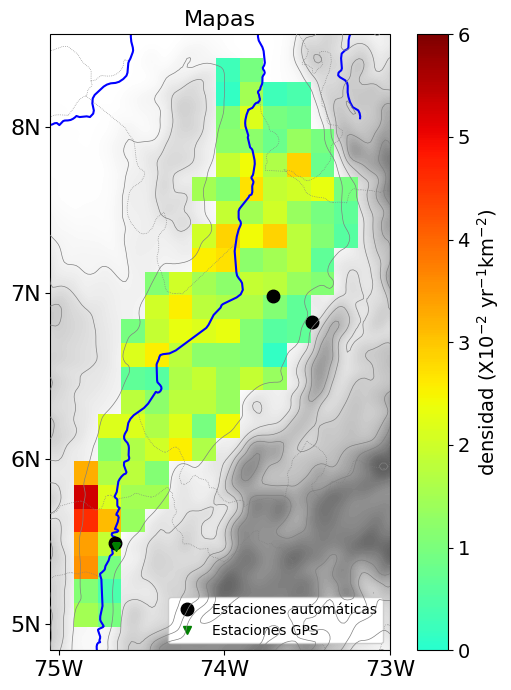

In [51]:
#***********************************
# Configura el mapa
fig = plt.figure(figsize=(7,8))
ax1 = plt.axes(projection=ccrs.Mercator(central_longitude=-75))
ax1.set_title('Mapas',fontsize=16)
extent = [-75.05, -73.05, 4.84, 8.56]
ax1.set_extent(extent)
ax1.set_xticks(np.arange(-75,-72),crs=ccrs.PlateCarree()) # Configura los indicadores de longitud
ax1.set_yticks(np.arange(5,9),crs=ccrs.PlateCarree()) # Configura los indicadores de latitud
lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='',dateline_direction_label=True) # Formata longitud
lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='') # Formata Latitud  
ax1.xaxis.set_major_formatter(lon_formatter) # Configura Longitud
ax1.yaxis.set_major_formatter(lat_formatter) # Configura Latitud
ax1.tick_params(labelsize=16)

#***********************************
# Ríos, fronteras, etc:

rios = cfeature.NaturalEarthFeature(
       category='physical',
       name='rivers_lake_centerlines',
       scale='10m',
       facecolor='none' )
limites_dep = cfeature.NaturalEarthFeature(
   category='cultural',
   name='admin_1_states_provinces_lines',
   scale='10m',
   facecolor='none')
limites_int = cfeature.NaturalEarthFeature(
   category='cultural',
   name='admin_0_countries',
   scale='10m',
   facecolor='none')
ax1.add_feature(limites_int, edgecolor='0.5',linewidth=0.5, linestyle=':') #estos dos son opcionales
ax1.add_feature(limites_dep, edgecolor='0.5',linewidth=0.5, linestyle=':')
ax1.add_feature(rios, edgecolor='blue', linewidth=1.5 ) # los ríos son importantes

#***********************************
#datos de altura:

var2 = Dataset(PATH_DRIVE + PATH_DADOS + FILE_RELIEVE, mode='r')
xtopo=np.arange(var2.variables['x_range'][0],var2.variables['x_range'][1]+0.5*var2.variables['spacing'][0],var2.variables['spacing'][0])
ytopo=np.arange(var2.variables['y_range'][0],var2.variables['y_range'][1]+0.5*var2.variables['spacing'][1],var2.variables['spacing'][1])
z=var2.variables['z'][:]
var2.close()
xt0,yt0=np.meshgrid(xtopo,ytopo)
z=np.reshape(z,xt0.shape)[::-1,:]
# suavizar los datos de altura:
z=gaussian_filter(z,2)
# niveles de elevación en escala de grises
plt.contourf(xt0,yt0,z, cmap='Greys', levels=np.arange(0,5100,50), zorder=0, transform=ccrs.PlateCarree(),alpha=1)
# líneas de contorno de elevación
plt.contour(xt0,yt0,z,levels=np.arange(0,5100,500),colors='gray',linewidths=[0.5],zorder=10,transform=ccrs.PlateCarree())

#***********************************
# Una escala de colores especial (opcional):
cmap = plt.get_cmap('jet')
jet2 = truncate_colormap(cmap, 0.4, 1)

#***********************************
# Inserta el histograma en el Mapa
count.T[np.where(count.T==0)]=np.nan # para que no grafique los ceros
im = ax1.pcolormesh( x_coord, y_coord, count.T*100, vmin = 0, vmax = 6, cmap = jet2, transform=ccrs.PlateCarree() )
cb=plt.colorbar(im, ax = ax1)
cb.ax.tick_params(labelsize=14)
cb.set_label('densidad (X10$^{-2}$ yr$^{-1}$km$^{-2}$)', size=14)

#***********************************
# coloca la posición de las estaciones
lat_est = []
lon_est = []
for est in estaciones:
  lat_est.append(estaciones[est]['lat'])
  lon_est.append(estaciones[est]['lon'])
ax1.plot(lon_est, lat_est, 'ko', markersize=9, transform=ccrs.PlateCarree(), label = 'Estaciones automáticas') 

#***********************************
# coloca la posición de las estaciones GPS
lat_gps = []
lon_gps = []
for est in gps:
  lat_gps.append(gps[est]['lat'])
  lon_gps.append(gps[est]['lon'])
ax1.plot(lon_gps, lat_gps, 'gv', markersize=6, transform=ccrs.PlateCarree(), label = 'Estaciones GPS') 

legend = ax1.legend(loc='lower right', framealpha = 1.0)
legend.get_frame().set_facecolor('white')

# plt.show()
plt.savefig(PATH_DRIVE + PATH_FIGURE + 'Mapa_eventos_Temp_Nocturno_20h_a_06h.png', format='png', bbox_inches = 'tight' )

#**Análisis de eventos**

In [52]:
def list_average(list_coord, window_size):

  i = 0
  moving_averages = []
  while i < len(list_coord) - window_size + 1:
    this_window = list_coord[i : i + window_size]
    window_average = sum(this_window) / window_size
    moving_averages.append(window_average)
    i += 1
  return moving_averages

In [53]:
# Configuración de parámetros

estacion = 'vizcaina'
coordenadas_estacion = np.array([estaciones[estacion]['lon'], estaciones[estacion]['lat']])

In [54]:
# Estimando punto medio de cada cuadro
x_media_coord = list_average(x_coord, 2)
y_media_coord = list_average(y_coord, 2)

# Creando matriz con los valores de los puntos medios de la malla de eventos del histograma
a = np.array([[i, j] for i in x_media_coord 
                 for j in y_media_coord])
b = np.reshape(a, (14, 26, 2))

# Encontrando el cuadro con la estación usando la heurística de la distancia
distancia = np.linalg.norm(b - coordenadas_estacion, axis=2)
pos_dist = np.where(distancia == np.min(distancia))
list_pos = [[pos_dist[0][0], pos_dist[1][0]], 
            [pos_dist[0][0], pos_dist[1][0] - 1], 
            [pos_dist[0][0], pos_dist[1][0]+1]]

list_pos

[[9, 14], [9, 13], [9, 15]]

In [55]:
# Conociendo el cuadro que engloba la estación, encontramos los eventos que componen ese cuadro
# pd.set_option('display.max_rows', None)
list_df = []
n_acu = 0 

for pos in list_pos:
  pos_cuadro_pal = b[pos[0], pos[1]]
  func_dist = lambda df : ((df[0] - df[1])**2 + (df[2] - df[3])**2)**(1/2)
  dfaux_nocturno = df_nocturno.copy()
  dfaux_nocturno['lon_t_palanquero'] = pos_cuadro_pal[0]
  dfaux_nocturno['lat_t_palanquero'] = pos_cuadro_pal[1]
  dfaux_nocturno['distancia'] = dfaux_nocturno[['LON', 'lon_t_palanquero', 'LAT', 'lat_t_palanquero']].apply(func_dist, axis=1)

  # Ordenar los datos, encontrar el número de eventos asociado a ese cuadro, seleccionarlos y guardarlos
  dfaux_nocturno = dfaux_nocturno.sort_values(by=['distancia']).reset_index(drop = True)
  n = count[pos[0], pos[1]]*(area*7*10/24)
  print(f'Número de eventos en grilla {pos_cuadro_pal} ---> {n}')
  n_acu += n 
  dfaux_eventos = dfaux_nocturno.loc[:n-1]
  list_df.append(dfaux_eventos)

print(f"Total de eventos : {int(n_acu)}")

dfselect = pd.concat(list_df)
dfselect.to_csv(PATH_DRIVE + PATH_DADOS + f'eventos_{estacion}_2.csv', header=True, index=False, sep = ';')

Número de eventos en grilla [-73.69285714   6.91461538] ---> 8.0
Número de eventos en grilla [-73.69285714   6.77153846] ---> 4.0
Número de eventos en grilla [-73.69285714   7.05769231] ---> 12.999999999999998
Total de eventos : 25


In [56]:
### Coger los 16 eventos (cuadro de la estación) y ver en que horario aparecen
# count[1:4, 3:7]*(area*7*10/24)

# **Mapa con eventos diurnos (07h hasta 20h)**


In [57]:
df_diurno = dfTemp.loc[(dfTemp['hora'] >= '07') & (dfTemp['hora'] < '20')]

In [58]:
#***********************************
# Estima el histograma 2D de los campos  
count, x_coord, y_coord = np.histogram2d(np.array(df_diurno['LON'], dtype=float),
                                          np.array(df_diurno['LAT'], dtype=float), bins = [14, 26], range= [[-75.05,-73.05],[4.84,8.56]])

area = 15.93*15.91
count = count/(area*7*8/24) #Poner en densidad == eventos/ km cuadrados * años

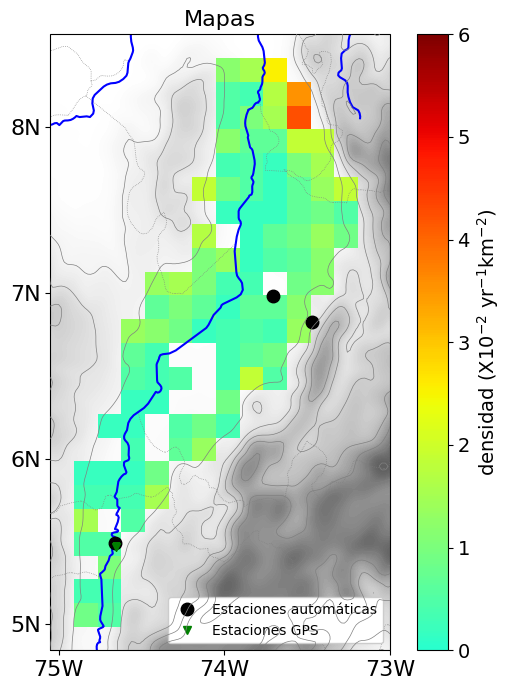

In [59]:
#***********************************
# Configura el mapa
fig = plt.figure(figsize=(7,8))
ax1 = plt.axes(projection=ccrs.Mercator(central_longitude=-75))
ax1.set_title('Mapas',fontsize=16)
extent = [-75.05, -73.05, 4.84, 8.56]
ax1.set_extent(extent)
ax1.set_xticks(np.arange(-75,-72),crs=ccrs.PlateCarree()) # Configura los indicadores de longitud
ax1.set_yticks(np.arange(5,9),crs=ccrs.PlateCarree()) # Configura los indicadores de latitud
lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='',dateline_direction_label=True) # Formata longitud
lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='') # Formata Latitud  
ax1.xaxis.set_major_formatter(lon_formatter) # Configura Longitud
ax1.yaxis.set_major_formatter(lat_formatter) # Configura Latitud
ax1.tick_params(labelsize=16)

#***********************************
# Ríos, fronteras, etc:

rios = cfeature.NaturalEarthFeature(
       category='physical',
       name='rivers_lake_centerlines',
       scale='10m',
       facecolor='none' )
limites_dep = cfeature.NaturalEarthFeature(
   category='cultural',
   name='admin_1_states_provinces_lines',
   scale='10m',
   facecolor='none')
limites_int = cfeature.NaturalEarthFeature(
   category='cultural',
   name='admin_0_countries',
   scale='10m',
   facecolor='none')
ax1.add_feature(limites_int, edgecolor='0.5',linewidth=0.5, linestyle=':') #estos dos son opcionales
ax1.add_feature(limites_dep, edgecolor='0.5',linewidth=0.5, linestyle=':')
ax1.add_feature(rios, edgecolor='blue', linewidth=1.5 ) # los ríos son importantes

#***********************************
#datos de altura:

var2 = Dataset(PATH_DRIVE + PATH_DADOS + FILE_RELIEVE, mode='r')
xtopo=np.arange(var2.variables['x_range'][0],var2.variables['x_range'][1]+0.5*var2.variables['spacing'][0],var2.variables['spacing'][0])
ytopo=np.arange(var2.variables['y_range'][0],var2.variables['y_range'][1]+0.5*var2.variables['spacing'][1],var2.variables['spacing'][1])
z=var2.variables['z'][:]
var2.close()
xt0,yt0=np.meshgrid(xtopo,ytopo)
z=np.reshape(z,xt0.shape)[::-1,:]
# suavizar los datos de altura:
z=gaussian_filter(z,2)
# niveles de elevación en escala de grises
plt.contourf(xt0,yt0,z, cmap='Greys', levels=np.arange(0,5100,50), zorder=0, transform=ccrs.PlateCarree(),alpha=1)
# líneas de contorno de elevación
plt.contour(xt0,yt0,z,levels=np.arange(0,5100,500),colors='gray',linewidths=[0.5],zorder=10,transform=ccrs.PlateCarree())

#***********************************
# Una escala de colores especial (opcional):
cmap = plt.get_cmap('jet')
jet2 = truncate_colormap(cmap, 0.4, 1)

#***********************************
# Inserta el histograma en el Mapa
count.T[np.where(count.T==0)]=np.nan # para que no grafique los ceros
im = ax1.pcolormesh( x_coord, y_coord, count.T*100, vmin = 0, vmax = 6, cmap = jet2, transform=ccrs.PlateCarree() )
cb=plt.colorbar(im, ax = ax1)
cb.ax.tick_params(labelsize=14)
cb.set_label('densidad (X10$^{-2}$ yr$^{-1}$km$^{-2}$)', size=14)

#***********************************
# coloca la posición de las estaciones
lat_est = []
lon_est = []
for est in estaciones:
  lat_est.append(estaciones[est]['lat'])
  lon_est.append(estaciones[est]['lon'])
ax1.plot(lon_est, lat_est, 'ko', markersize=9, transform=ccrs.PlateCarree(), label = 'Estaciones automáticas') 

#***********************************
# coloca la posición de las estaciones GPS
lat_gps = []
lon_gps = []
for est in gps:
  lat_gps.append(gps[est]['lat'])
  lon_gps.append(gps[est]['lon'])
ax1.plot(lon_gps, lat_gps, 'gv', markersize=6, transform=ccrs.PlateCarree(), label = 'Estaciones GPS') 

legend = ax1.legend(loc='lower right', framealpha = 1.0)
legend.get_frame().set_facecolor('white')

# plt.show()
plt.savefig(PATH_DRIVE + PATH_FIGURE + 'Mapa_eventos_Temp_Diurno_12h_a_20h.png', format='png', bbox_inches = 'tight' )

In [ ]:
np.nanmax(count)*100

6.087511014590243